In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('D:\stranger things\dataset.csv')



D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


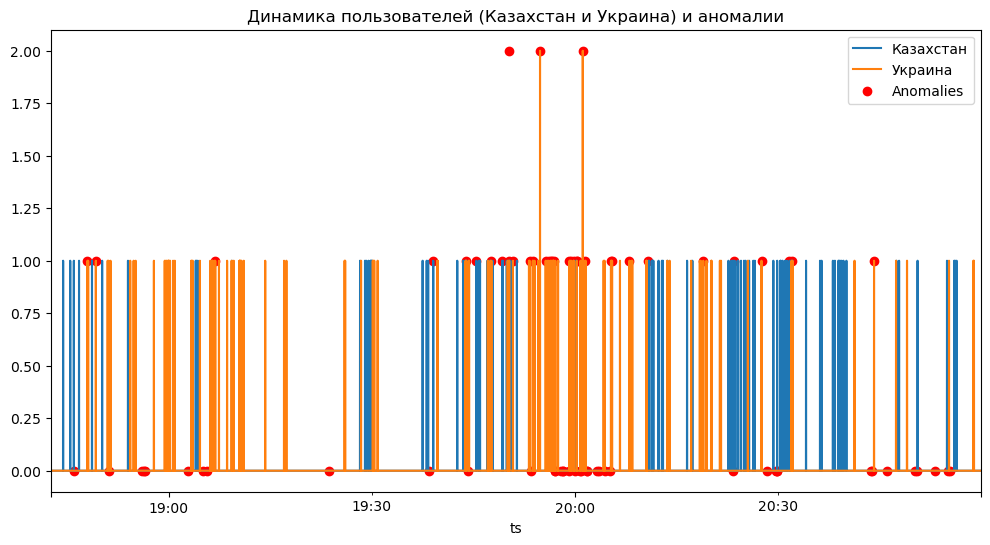

geo_country_title_ru  Казахстан  Украина  anomaly_score
ts                                                     
2024-12-07 18:46:00         0.0      0.0             -1
2024-12-07 18:47:58         0.0      1.0             -1
2024-12-07 18:49:12         0.0      1.0             -1
2024-12-07 18:51:13         0.0      0.0             -1
2024-12-07 18:55:57         0.0      0.0             -1
...                         ...      ...            ...
2024-12-07 20:50:12         0.0      0.0             -1
2024-12-07 20:50:32         0.0      0.0             -1
2024-12-07 20:53:17         0.0      0.0             -1
2024-12-07 20:55:13         0.0      0.0             -1
2024-12-07 20:55:23         0.0      0.0             -1

[76 rows x 3 columns]


In [10]:
df['ts'] = pd.to_datetime(df['ts'])
df_grouped = df.groupby(['ts', 'geo_country_title_ru'])['randPAS_user_passport_id'].nunique().reset_index()
df_grouped.rename(columns={'randPAS_user_passport_id': 'user_count'}, inplace=True)
df_pivot = df_grouped.pivot(index='ts', columns='geo_country_title_ru', values='user_count').fillna(0)

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(df_pivot)
df_kz_ua = df_pivot.copy()
df_kz_ua['anomaly_score'] = iso_forest.predict(df_kz_ua)

df_kz_ua = df_kz_ua[['Казахстан', 'Украина', 'anomaly_score']]
anomalies = df_kz_ua[df_kz_ua['anomaly_score'] == -1]

df_kz_ua.drop(columns=['anomaly_score']).plot(figsize=(12, 6))
plt.scatter(anomalies.index, anomalies.drop(columns=['anomaly_score']).sum(axis=1), color='red', label='Anomalies')
plt.legend()
plt.title('Динамика пользователей (Казахстан и Украина) и аномалии')
plt.show()

print(anomalies)


D:\anaconda\Lib\site-packages\sklearn\base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


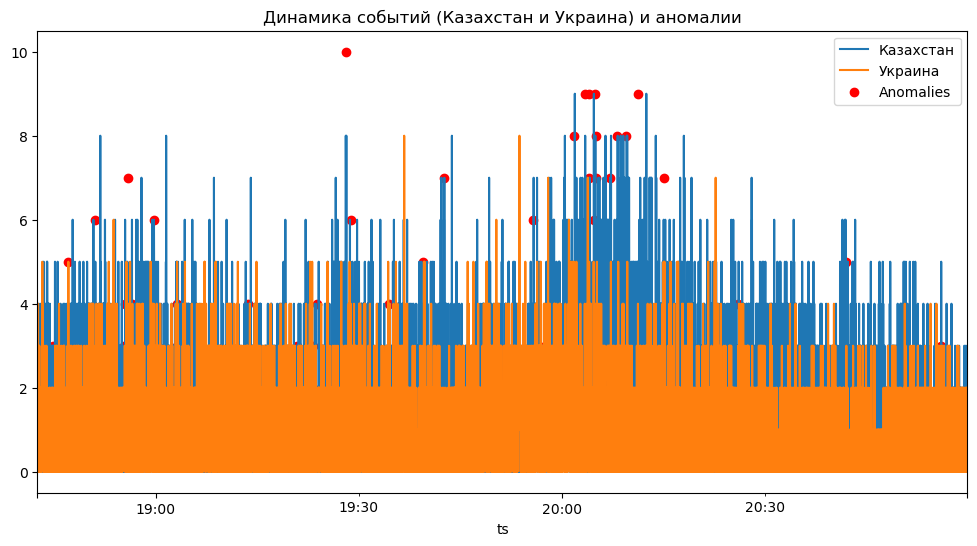

geo_country_title_ru  Казахстан  Украина  anomaly_score
ts                                                     
2024-12-07 18:43:28         1.0      2.0             -1
2024-12-07 18:44:48         2.0      1.0             -1
2024-12-07 18:44:57         1.0      1.0             -1
2024-12-07 18:47:00         0.0      1.0             -1
2024-12-07 18:47:06         0.0      5.0             -1
...                         ...      ...            ...
2024-12-07 20:32:13         2.0      1.0             -1
2024-12-07 20:40:06         1.0      0.0             -1
2024-12-07 20:42:05         2.0      3.0             -1
2024-12-07 20:46:20         0.0      1.0             -1
2024-12-07 20:56:05         0.0      3.0             -1

[83 rows x 3 columns]


In [12]:

df_grouped = df.groupby(['ts', 'geo_country_title_ru']).size().reset_index(name='event_count')
df_grouped.rename(columns={'event_count': 'event_count'}, inplace=True)
df_pivot = df_grouped.pivot(index='ts', columns='geo_country_title_ru', values='event_count').fillna(0)

iso_forest = IsolationForest(contamination=0.01, random_state=42)
iso_forest.fit(df_pivot)
df_kz_ua = df_pivot.copy()
df_kz_ua['anomaly_score'] = iso_forest.predict(df_kz_ua)

df_kz_ua = df_kz_ua[['Казахстан', 'Украина', 'anomaly_score']]
anomalies = df_kz_ua[df_kz_ua['anomaly_score'] == -1]

df_kz_ua.drop(columns=['anomaly_score']).plot(figsize=(12, 6))
plt.scatter(anomalies.index, anomalies.drop(columns=['anomaly_score']).sum(axis=1), color='red', label='Anomalies')
plt.legend()
plt.title('Динамика событий (Казахстан и Украина) и аномалии')
plt.show()

print(anomalies)

In [18]:
from prophet import Prophet


20:50:09 - cmdstanpy - INFO - Chain [1] start processing
20:50:13 - cmdstanpy - INFO - Chain [1] done processing


                      ds    y      yhat     error  abs_error
55   2024-12-07 18:43:27  5.0  1.816447  3.183553   3.183553
84   2024-12-07 18:43:56  5.0  1.812775  3.187225   3.187225
86   2024-12-07 18:43:58  5.0  1.812522  3.187478   3.187478
155  2024-12-07 18:45:07  5.0  1.803788  3.196212   3.196212
156  2024-12-07 18:45:08  5.0  1.803661  3.196339   3.196339
...                  ...  ...       ...       ...        ...
7893 2024-12-07 20:54:05  4.0  1.088573  2.911427   2.911427
7960 2024-12-07 20:55:12  4.0  1.056322  2.943678   2.943678
8014 2024-12-07 20:56:06  5.0  1.030328  3.969672   3.969672
8062 2024-12-07 20:56:54  4.0  1.007223  2.992777   2.992777
8105 2024-12-07 20:57:37  4.0  0.986524  3.013476   3.013476

[309 rows x 5 columns]


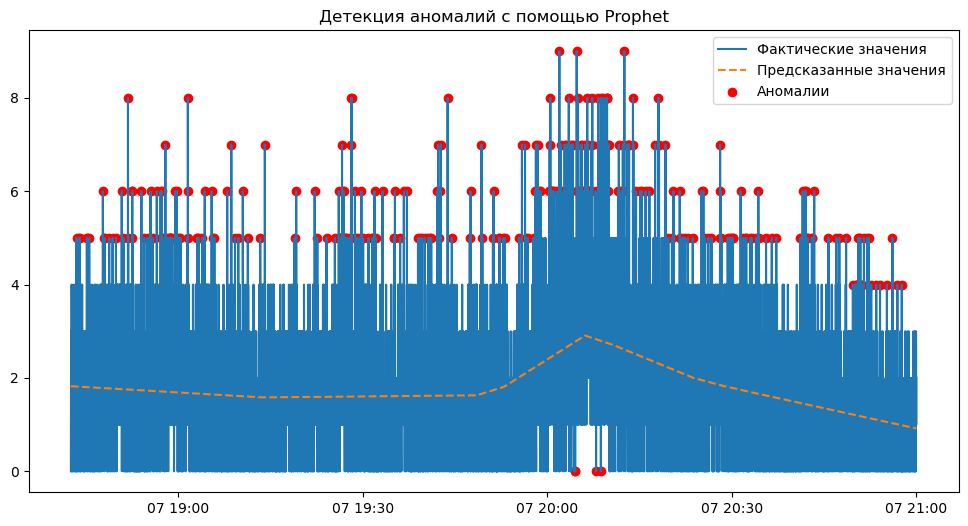

In [20]:

df_prophet = df_pivot[['Казахстан']].reset_index()
df_prophet.columns = ['ds', 'y']  

model = Prophet()
model.fit(df_prophet)

future = model.make_future_dataframe(periods=0)  
forecast = model.predict(future)

df_prophet['yhat'] = forecast['yhat']

df_prophet['error'] = df_prophet['y'] - df_prophet['yhat']
df_prophet['abs_error'] = df_prophet['error'].abs()

threshold = df_prophet['abs_error'].mean() + 2 * df_prophet['abs_error'].std()
anomalies = df_prophet[df_prophet['abs_error'] > threshold]
print(anomalies)

plt.figure(figsize=(12, 6))
plt.plot(df_prophet['ds'], df_prophet['y'], label='Фактические значения')
plt.plot(df_prophet['ds'], df_prophet['yhat'], label='Предсказанные значения', linestyle='--')
plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Аномалии')
plt.legend()
plt.title('Детекция аномалий с помощью Prophet')
plt.show()


20:51:28 - cmdstanpy - INFO - Chain [1] start processing
20:51:31 - cmdstanpy - INFO - Chain [1] done processing


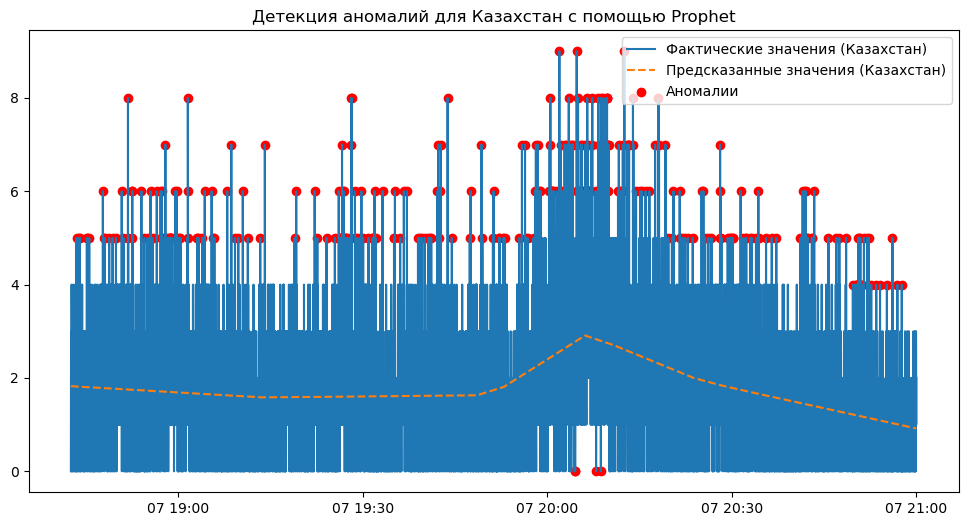

20:51:36 - cmdstanpy - INFO - Chain [1] start processing
20:51:38 - cmdstanpy - INFO - Chain [1] done processing


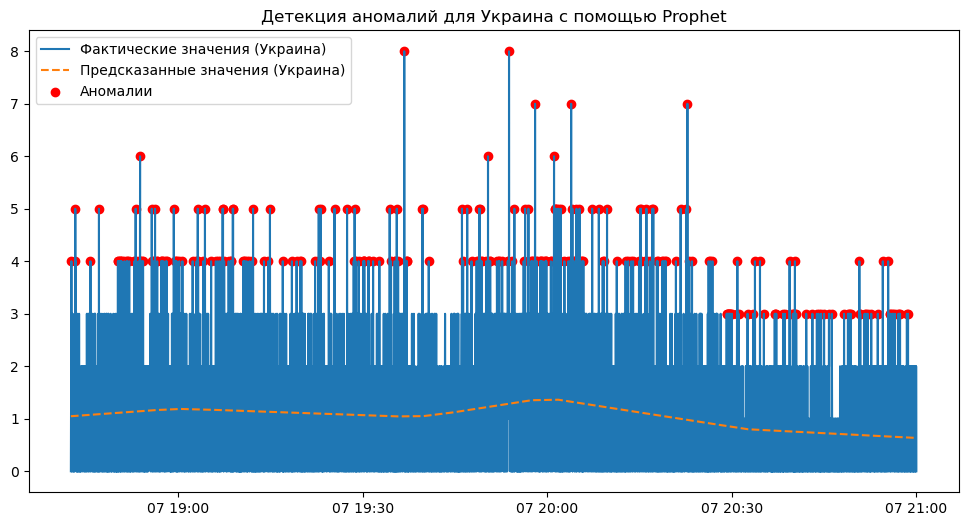

In [22]:
countries = ['Казахстан', 'Украина']

for country in countries:
    df_prophet = df_pivot[[country]].reset_index()
    df_prophet.columns = ['ds', 'y']

    model = Prophet()
    model.fit(df_prophet)

    future = model.make_future_dataframe(periods=0)
    forecast = model.predict(future)

    df_prophet['yhat'] = forecast['yhat']
    df_prophet['error'] = df_prophet['y'] - df_prophet['yhat']
    df_prophet['abs_error'] = df_prophet['error'].abs()
    threshold = df_prophet['abs_error'].mean() + 2 * df_prophet['abs_error'].std()
    anomalies = df_prophet[df_prophet['abs_error'] > threshold]

    plt.figure(figsize=(12, 6))
    plt.plot(df_prophet['ds'], df_prophet['y'], label=f'Фактические значения ({country})')
    plt.plot(df_prophet['ds'], df_prophet['yhat'], label=f'Предсказанные значения ({country})', linestyle='--')
    plt.scatter(anomalies['ds'], anomalies['y'], color='red', label='Аномалии')
    plt.legend()
    plt.title(f'Детекция аномалий для {country} с помощью Prophet')
    plt.show()